In [2]:
!pip3 install tensorflow

In [3]:
import torch
import torch.nn as nn
import numpy as np
import pandas as pd
from sklearn.preprocessing import MinMaxScaler
from torch.utils.data import Dataset, DataLoader
import matplotlib.pyplot as plt


In [4]:
class Predictor(nn.Module):
    def __init__(self, input_size=1, hidden_size=32, num_layers=2):
        super(Predictor, self).__init__()
        self.hidden_size = hidden_size
        self.num_layers = num_layers
        
        self.lstm = nn.LSTM(input_size, hidden_size, num_layers, batch_first=True)
        self.fc = nn.Linear(hidden_size, 1)
    
    def forward(self, x):
        h0 = torch.zeros(self.num_layers, x.size(0), self.hidden_size).to(x.device)
        c0 = torch.zeros(self.num_layers, x.size(0), self.hidden_size).to(x.device)
        
        out, _ = self.lstm(x, (h0, c0))
        out = self.fc(out[:, -1, :])
        return out

In [6]:
def prepare_country_data(country_data, sequence_length=5):
    # Scale the data
    scaler = MinMaxScaler()
    scaled_data = scaler.fit_transform(country_data.reshape(-1, 1))
    
    # Create sequences
    X, y = [], []
    for i in range(len(scaled_data) - sequence_length):
        X.append(scaled_data[i:(i + sequence_length)])
        y.append(scaled_data[i + sequence_length])
    
    return np.array(X), np.array(y), scaler


In [7]:
def train_model(X, y, epochs=200):
    # Create dataset and dataloader
    X_tensor = torch.FloatTensor(X)
    y_tensor = torch.FloatTensor(y)
    dataset = torch.utils.data.TensorDataset(X_tensor, y_tensor)
    train_loader = DataLoader(dataset, batch_size=8, shuffle=True)
    
    # Initialize model
    model = Predictor(input_size=1)
    criterion = nn.MSELoss()
    optimizer = torch.optim.Adam(model.parameters(), lr=0.001)
    
    # Training
    for epoch in range(epochs):
        model.train()
        total_loss = 0
        for batch_X, batch_y in train_loader:
            optimizer.zero_grad()
            outputs = model(batch_X)
            loss = criterion(outputs, batch_y)
            loss.backward()
            optimizer.step()
            total_loss += loss.item()
            
        if (epoch + 1) % 50 == 0:
            print(f'Epoch [{epoch+1}/{epochs}], Loss: {total_loss/len(train_loader):.4f}')
    
    return model

In [8]:
def predict_future(model, last_sequence, scaler, n_future=5):
    model.eval()
    current_sequence = last_sequence.copy()
    predictions = []
    
    with torch.no_grad():
        for _ in range(n_future):
            sequence = torch.FloatTensor(current_sequence).unsqueeze(0)
            pred = model(sequence)
            predictions.append(pred.numpy())
            current_sequence = np.vstack((current_sequence[1:], pred.numpy()))
    
    predictions = np.array(predictions).reshape(-1, 1)
    predictions = scaler.inverse_transform(predictions)
    
    return predictions.flatten()


In [9]:
df = pd.read_csv('../datasets/expected_schooling.csv')
df.head()
df.replace("..", pd.NA, inplace=True)
# Forward fill first, then backward fill to handle any remaining NAs at the start
df.rename(columns={'entity': 'Country'}, inplace=True)
df = df.ffill().bfill()
df.head()

,Country,Expected Years of Schooling (1990),Expected Years of Schooling (1991),Expected Years of Schooling (1992),Expected Years of Schooling (1993),Expected Years of Schooling (1994),Expected Years of Schooling (1995),Expected Years of Schooling (1996),Expected Years of Schooling (1997),Expected Years of Schooling (1998),...,Expected Years of Schooling (2012),Expected Years of Schooling (2013),Expected Years of Schooling (2014),Expected Years of Schooling (2015),Expected Years of Schooling (2016),Expected Years of Schooling (2017),Expected Years of Schooling (2018),Expected Years of Schooling (2019),Expected Years of Schooling (2020),Expected Years of Schooling (2021)
0,Afghanistan,2.50405,2.80655,3.10905,3.41155,3.714050,4.016550,4.319050,4.621550,4.924050,...,9.577323,9.875836,10.174350,10.180150,10.185950,10.191750,10.197550,10.263844,10.263844,10.263844
1,Angola,3.53748,3.32483,3.30209,3.38587,3.469650,3.553430,3.637210,3.720990,3.804770,...,10.082500,10.604900,11.127300,11.649700,12.172090,12.172100,12.172100,12.172100,12.172100,12.172100
2,Albania,11.60293,11.76358,10.66378,10.12650,10.091150,10.166170,10.228450,10.505080,10.669440,...,14.586650,14.925640,15.252420,15.076300,14.804600,14.816130,14.695620,14.818920,14.448000,14.448000
3,Andorra,10.79878,10.79878,10.79878,10.79878,10.798780,10.798780,10.798780,10.798780,10.798780,...,13.524016,13.138841,13.495076,13.140280,13.300239,13.046476,13.300239,13.300239,13.300239,13.300239
4,United Arab Emirates,10.47456,10.82239,10.65938,10.68766,10.806515,10.925369,11.044223,11.163078,11.281932,...,12.945893,13.064747,13.183602,13.302456,13.421310,14.344100,15.019120,15.694140,15.717690,15.717690


In [10]:
cols = [col for col in df.columns if 'Expected' in col]
    
sequence_length = 5
predictions_by_country = {}
selected_countries = ['United States', 'China', 'Japan', 'Germany', 'United Kingdom']

In [11]:
for country in df['Country']:
        print(f"\nTraining model for {country}")
        
        # Get country data
        country_data = df[df['Country'] == country][cols].values.flatten()

        country_data = country_data.astype(float)
        
        # Prepare data
        X, y, scaler = prepare_country_data(country_data, sequence_length)
        
        if len(X) > 0:  # Check if we have enough data
            # Train model
            model = train_model(X, y)
            
            # Make predictions
            last_sequence = scaler.transform(country_data[-sequence_length:].reshape(-1, 1))
            predictions = predict_future(model, last_sequence, scaler)
            predictions_by_country[country] = predictions
    


Training model for Afghanistan
Epoch [50/200], Loss: 0.0031
Epoch [100/200], Loss: 0.0005
Epoch [150/200], Loss: 0.0004
Epoch [200/200], Loss: 0.0004

Training model for Angola
Epoch [50/200], Loss: 0.0023
Epoch [100/200], Loss: 0.0014
Epoch [150/200], Loss: 0.0012
Epoch [200/200], Loss: 0.0013

Training model for Albania
Epoch [50/200], Loss: 0.0146
Epoch [100/200], Loss: 0.0075
Epoch [150/200], Loss: 0.0023
Epoch [200/200], Loss: 0.0015

Training model for Andorra
Epoch [50/200], Loss: 0.0188
Epoch [100/200], Loss: 0.0106
Epoch [150/200], Loss: 0.0093
Epoch [200/200], Loss: 0.0137

Training model for United Arab Emirates
Epoch [50/200], Loss: 0.0030
Epoch [100/200], Loss: 0.0028
Epoch [150/200], Loss: 0.0028
Epoch [200/200], Loss: 0.0032

Training model for Argentina
Epoch [50/200], Loss: 0.0103
Epoch [100/200], Loss: 0.0083
Epoch [150/200], Loss: 0.0077
Epoch [200/200], Loss: 0.0041

Training model for Armenia
Epoch [50/200], Loss: 0.0319
Epoch [100/200], Loss: 0.0202
Epoch [150/20

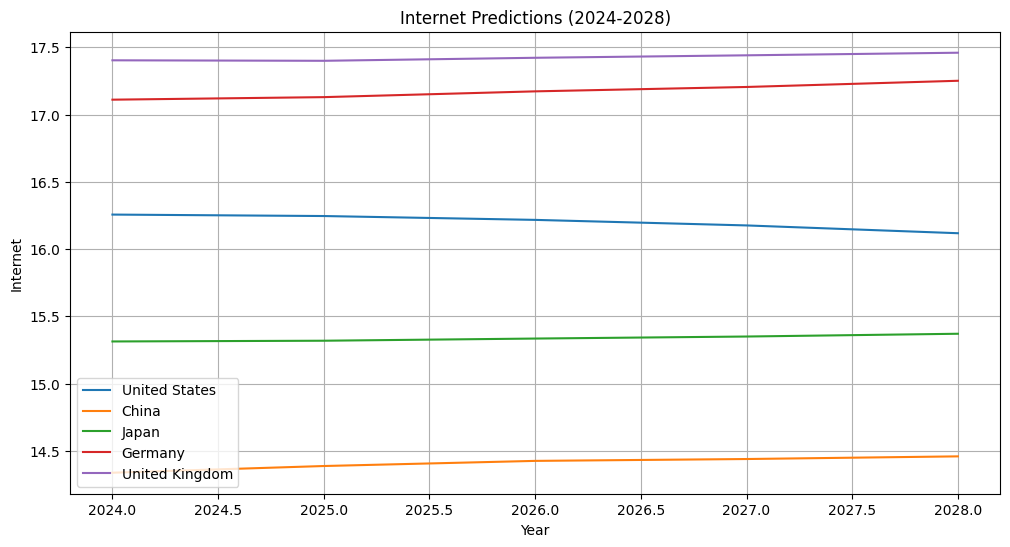


Predicted Internet (2024-2028):

United States:
2024: $16.26
2025: $16.25
2026: $16.22
2027: $16.18
2028: $16.12

China:
2024: $14.34
2025: $14.39
2026: $14.42
2027: $14.44
2028: $14.46

Japan:
2024: $15.31
2025: $15.32
2026: $15.33
2027: $15.35
2028: $15.37

Germany:
2024: $17.11
2025: $17.13
2026: $17.17
2027: $17.21
2028: $17.25

United Kingdom:
2024: $17.40
2025: $17.40
2026: $17.42
2027: $17.44
2028: $17.46


In [13]:
plt.figure(figsize=(12, 6))
for country in selected_countries:
    if country in predictions_by_country:
        plt.plot(range(2024, 2029), predictions_by_country[country], label=country)
plt.title('Internet Predictions (2024-2028)')
plt.xlabel('Year')
plt.ylabel('Internet')
plt.legend()
plt.grid(True)
plt.show()
    
    # Print predictions for selected countries
print("\nPredicted Internet (2024-2028):")
for country in selected_countries:
    if country in predictions_by_country:
        print(f"\n{country}:")
        for year, pred in zip(range(2024, 2029), predictions_by_country[country]):
            print(f"{year}: ${pred:,.2f}")

In [14]:
# Export predictions to CSV
predictions_df = pd.DataFrame()
predictions_df['Country'] = list(predictions_by_country.keys())

for year in range(2024, 2029):
    year_predictions = []
    for country in predictions_df['Country']:
        if country in predictions_by_country:
            year_predictions.append(predictions_by_country[country][year-2024])
        else:
            year_predictions.append(None)
    predictions_df[f'{year} Expected Schooling'] = year_predictions

predictions_df.to_csv('../lstm_datasets/expected_schooling_prediction.csv', index=False)
print("\nPredictions exported to lstm_datasets/expected_schooling_prediction.csv")



Predictions exported to lstm_datasets/expected_schooling_prediction.csv
